# Evaluation with ML
The point of this section is to check whether the generated data can be used to train new models. I will do this mostly by training a classifier on the generated data and then perform inference on the original data. The 'test set' data will in this case give a good indication of how usable the data is.

In [10]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import xgboost as xgb
import pandas as pd
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

C:\Users\C64062\anaconda3\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)
C:\Users\C64062\anaconda3\envs\fastai\lib\importlib\_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 192 from C header, got 216 from PyObject
  return f(*args, **kwds)


In [2]:
def get_data(path_real, path_fake, real_sep=';', fake_sep=','):
    real = pd.read_csv(path_real, sep=real_sep)
    fake = pd.read_csv(path_fake, sep=fake_sep)
    real = real.sample(len(fake))
    real = real[fake.columns]
    for col in fake.columns:
        fake[col] = fake[col].astype(real[col].dtype)
    return real, fake

In [3]:
class FakeDataEval:
    def __init__(self, real_data, fake_data, dep_var: str, clf=XGBClassifier, source='fake', **kwargs):
        fake_data.columns = real_data.columns
        self.real_data = real_data
        self.fake_data = fake_data
        self.dep_var = dep_var
        if source == 'fake':
            self.source = fake_data
            self.target = real_data
        elif source == 'real':
            self.source = real_data
            self.target = fake_data
            
            
        if len(self.source[dep_var].unique()) > 2:
            target_func = lambda x: (x > x.mean()).astype('int')
            print(f'Label has more than 2 values. Comparing to mean...')
            self.y_source = target_func(self.source[dep_var])
            self.y_target = target_func(self.target[dep_var])
        else:
            self.y_source = self.source[dep_var]
            self.y_target = self.target[dep_var]
            assert not self.y_source.isna().any(), f'target contains null values. Please fix and try again.'
            
        self.clf = clf(**kwargs)
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.source.drop([dep_var], axis=1), self.y_source, test_size=0.2, shuffle=True)
#         self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(self.source, self.y_source, test_size=0.2, shuffle=True)

    def fit(self, verbose=True):
        self.clf.fit(self.x_train, self.y_train, eval_set=[(self.x_test, self.y_test)], verbose=verbose)
        return self.clf.score(self.x_test, self.y_test)

    def score(self):
        return self.clf.score(self.target.drop([self.dep_var], axis=1), self.y_target)
#         return self.clf.score(self.target, self.y_target)


In [4]:
real, fake = get_data('../data/berka/berka_cat.csv', 'samples/berka_sample.csv')

/home/bauke/anaconda3/envs/p3.6/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3214: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  if (yield from self.run_code(code, result)):


In [7]:
for col in fake.select_dtypes(include=['object']):
    fake[col] = pd.factorize(fake[col])[0]
    real[col] = pd.factorize(real[col])[0]

In [8]:
x = FakeDataEval(real, fake, 'trans_amount')
x.fit()
x.score()

Label has more than 2 values. Comparing to mean...
[0]	validation_0-error:0.1891
[1]	validation_0-error:0.1891
[2]	validation_0-error:0.18735
[3]	validation_0-error:0.18735
[4]	validation_0-error:0.18735
[5]	validation_0-error:0.1873
[6]	validation_0-error:0.1873
[7]	validation_0-error:0.1873
[8]	validation_0-error:0.1842
[9]	validation_0-error:0.1873
[10]	validation_0-error:0.1873
[11]	validation_0-error:0.1873
[12]	validation_0-error:0.18725
[13]	validation_0-error:0.1847
[14]	validation_0-error:0.18715
[15]	validation_0-error:0.1868
[16]	validation_0-error:0.171
[17]	validation_0-error:0.1709
[18]	validation_0-error:0.1709
[19]	validation_0-error:0.1709
[20]	validation_0-error:0.171
[21]	validation_0-error:0.171
[22]	validation_0-error:0.17095
[23]	validation_0-error:0.171
[24]	validation_0-error:0.17095
[25]	validation_0-error:0.17095
[26]	validation_0-error:0.1687
[27]	validation_0-error:0.1685
[28]	validation_0-error:0.1683
[29]	validation_0-error:0.16845
[30]	validation_0-error:

0.71453

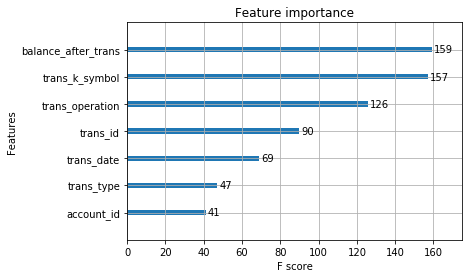

In [11]:
xgb.plot_importance(x.clf)

In [12]:
y = FakeDataEval(real, fake, 'trans_amount', source='real')
y.fit()
y.score()

Label has more than 2 values. Comparing to mean...
[0]	validation_0-error:0.17935
[1]	validation_0-error:0.1783
[2]	validation_0-error:0.1783
[3]	validation_0-error:0.1783
[4]	validation_0-error:0.1783
[5]	validation_0-error:0.17545
[6]	validation_0-error:0.16255
[7]	validation_0-error:0.1783
[8]	validation_0-error:0.1768
[9]	validation_0-error:0.1768
[10]	validation_0-error:0.1593
[11]	validation_0-error:0.17505
[12]	validation_0-error:0.17505
[13]	validation_0-error:0.16085
[14]	validation_0-error:0.16085
[15]	validation_0-error:0.1606
[16]	validation_0-error:0.16065
[17]	validation_0-error:0.1604
[18]	validation_0-error:0.16105
[19]	validation_0-error:0.16105
[20]	validation_0-error:0.16105
[21]	validation_0-error:0.161
[22]	validation_0-error:0.161
[23]	validation_0-error:0.16875
[24]	validation_0-error:0.16885
[25]	validation_0-error:0.1683
[26]	validation_0-error:0.1618
[27]	validation_0-error:0.1611
[28]	validation_0-error:0.1611
[29]	validation_0-error:0.16395
[30]	validation_0

0.7395

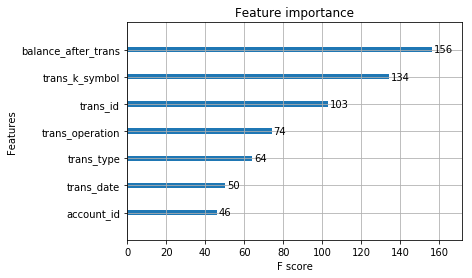

In [13]:
xgb.plot_importance(y.clf)


In [50]:
real, fake = get_data('Ticket')

In [51]:
y = FakeDataEval(real['num'], fake['num'], 'MktFare', source='real')
y.fit()
y.score()

Label has more than 2 values. Comparing to mean...
[0]	validation_0-error:0.391
[1]	validation_0-error:0.391
[2]	validation_0-error:0.38225
[3]	validation_0-error:0.382
[4]	validation_0-error:0.3791
[5]	validation_0-error:0.3768
[6]	validation_0-error:0.37915
[7]	validation_0-error:0.37535
[8]	validation_0-error:0.3778
[9]	validation_0-error:0.37395
[10]	validation_0-error:0.37455
[11]	validation_0-error:0.3744
[12]	validation_0-error:0.3729
[13]	validation_0-error:0.3731
[14]	validation_0-error:0.37325
[15]	validation_0-error:0.37225
[16]	validation_0-error:0.3733
[17]	validation_0-error:0.37195
[18]	validation_0-error:0.37185
[19]	validation_0-error:0.3718
[20]	validation_0-error:0.3721
[21]	validation_0-error:0.3725
[22]	validation_0-error:0.3723
[23]	validation_0-error:0.3725
[24]	validation_0-error:0.3726
[25]	validation_0-error:0.37225
[26]	validation_0-error:0.3724
[27]	validation_0-error:0.37235
[28]	validation_0-error:0.37205
[29]	validation_0-error:0.3715
[30]	validation_0-er

0.49195

In [52]:
y = FakeDataEval(real['num'], fake['num'], 'MktFare')
y.fit()
y.score()

Label has more than 2 values. Comparing to mean...
[0]	validation_0-error:0.1706
[1]	validation_0-error:0.1706
[2]	validation_0-error:0.1673
[3]	validation_0-error:0.1694
[4]	validation_0-error:0.17225
[5]	validation_0-error:0.16685
[6]	validation_0-error:0.1684
[7]	validation_0-error:0.17105
[8]	validation_0-error:0.16945
[9]	validation_0-error:0.1678
[10]	validation_0-error:0.1695
[11]	validation_0-error:0.16795
[12]	validation_0-error:0.1665
[13]	validation_0-error:0.1623
[14]	validation_0-error:0.1585
[15]	validation_0-error:0.1585
[16]	validation_0-error:0.1585
[17]	validation_0-error:0.15775
[18]	validation_0-error:0.15445
[19]	validation_0-error:0.15125
[20]	validation_0-error:0.1502
[21]	validation_0-error:0.14725
[22]	validation_0-error:0.1479
[23]	validation_0-error:0.14665
[24]	validation_0-error:0.1467
[25]	validation_0-error:0.14495
[26]	validation_0-error:0.14355
[27]	validation_0-error:0.14285
[28]	validation_0-error:0.1421
[29]	validation_0-error:0.14005
[30]	validation

0.49473